In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Loading

In [2]:
df = pd.read_excel('Cleaned Dataset/electricity_consumption (1).xlsx')
gdp_data_long_cleaned = pd.read_excel('Cleaned Dataset/gdp_data_long_cleaned_IMF.xlsx')
inflation_data_cleaned = pd.read_excel('Cleaned Dataset/inflation_data_cleaned_IMF.xlsx')

## Data Preparation

In [3]:
#electricity dataset
df.head()

,Year,Country Code,Country,IncomeGroup,Population,GDP per capita (current US$),Access to electricity (% of population),Inflation (annual %),Consumption (kWh per capita)
0,1960-01-01,ABW,Aruba,High income,54608.0,NaN,NaN,NaN,NaN
1,1960-01-01,AFE,Africa Eastern and Southern,NaN,130692579.0,141.385955,NaN,NaN,NaN
2,1960-01-01,AFG,Afghanistan,Low income,8622466.0,62.369375,NaN,NaN,NaN
3,1960-01-01,AFW,Africa Western and Central,NaN,97256290.0,107.053706,NaN,NaN,NaN
4,1960-01-01,AGO,Angola,Lower middle income,5357195.0,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Year                                     16960 non-null  datetime64[ns]
 1   Country Code                             16960 non-null  object        
 2   Country                                  16960 non-null  object        
 3   IncomeGroup                              13824 non-null  object        
 4   Population                               16665 non-null  float64       
 5   GDP per capita (current US$)             13202 non-null  float64       
 6   Access to electricity (% of population)  7348 non-null   float64       
 7   Inflation (annual %)                     10788 non-null  float64       
 8   Consumption (kWh per capita)             7790 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object

In [5]:
df.isna().sum()

Year                                          0
Country Code                                  0
Country                                       0
IncomeGroup                                3136
Population                                  295
GDP per capita (current US$)               3758
Access to electricity (% of population)    9612
Inflation (annual %)                       6172
Consumption (kWh per capita)               9170
dtype: int64

In [6]:
data_test = df.dropna(subset=['Consumption (kWh per capita)','IncomeGroup', 'Year'])
data_test.shape

(5859, 9)

In [7]:
data_test.isna().sum()

Year                                          0
Country Code                                  0
Country                                       0
IncomeGroup                                   0
Population                                    0
GDP per capita (current US$)                584
Access to electricity (% of population)    2840
Inflation (annual %)                        921
Consumption (kWh per capita)                  0
dtype: int64

In [8]:
data_test.columns

Index(['Year', 'Country Code', 'Country', 'IncomeGroup', 'Population',
       'GDP per capita (current US$)',
       'Access to electricity (% of population)', 'Inflation (annual %)',
       'Consumption (kWh per capita)'],
      dtype='object')

In [9]:
# gdp data
gdp_data_long_cleaned.head()

,Country,Year,GDP
0,Albania,1980,728.359
1,Algeria,1980,2462.085
2,Angola,1980,802.627
3,Antigua and Barbuda,1980,1920.249
4,Argentina,1980,8361.209


In [10]:
gdp_data_long_cleaned = gdp_data_long_cleaned.rename(columns={'GDP': 'GDP per capita (current US$)'})
gdp_data_long_cleaned.head()

,Country,Year,GDP per capita (current US$)
0,Albania,1980,728.359
1,Algeria,1980,2462.085
2,Angola,1980,802.627
3,Antigua and Barbuda,1980,1920.249
4,Argentina,1980,8361.209


In [11]:
gdp_data_long_cleaned.columns

Index(['Country', 'Year', 'GDP per capita (current US$)'], dtype='object')

In [12]:
gdp_data_long_cleaned.isna().sum()

Country                         0
Year                            0
GDP per capita (current US$)    0
dtype: int64

In [13]:
gdp_data_long_cleaned['Year'] = pd.to_datetime(gdp_data_long_cleaned['Year'], format='%Y')

In [14]:
# merge electricity and gdp
data_test_2 = pd.merge(data_test, gdp_data_long_cleaned[['Country', 'Year', 'GDP per capita (current US$)']], on=['Country', 'Year'], how='left')

In [15]:
data_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5859 entries, 0 to 5858
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Year                                     5859 non-null   datetime64[ns]
 1   Country Code                             5859 non-null   object        
 2   Country                                  5859 non-null   object        
 3   IncomeGroup                              5859 non-null   object        
 4   Population                               5859 non-null   float64       
 5   GDP per capita (current US$)_x           5275 non-null   float64       
 6   Access to electricity (% of population)  3019 non-null   float64       
 7   Inflation (annual %)                     4938 non-null   float64       
 8   Consumption (kWh per capita)             5859 non-null   float64       
 9   GDP per capita (current US$)_y           

In [16]:
data_test_2['GDP per capita (current US$)_x'] = data_test_2['GDP per capita (current US$)_x'].combine_first(data_test_2['GDP per capita (current US$)_y'])

In [17]:
data_test_2.head()

,Year,Country Code,Country,IncomeGroup,Population,GDP per capita (current US$)_x,Access to electricity (% of population),Inflation (annual %),Consumption (kWh per capita),GDP per capita (current US$)_y
0,1960-01-01,AUS,Australia,High income,10276477.0,1810.597443,NaN,3.728814,1825.625650,NaN
1,1960-01-01,AUT,Austria,High income,7047539.0,935.460427,NaN,1.945749,1814.676017,NaN
2,1960-01-01,BEL,Belgium,High income,9153489.0,1273.691659,NaN,0.299467,1576.338815,NaN
3,1960-01-01,CAN,Canada,High income,17909356.0,2259.250511,NaN,1.358696,5630.520718,NaN
4,1960-01-01,CHE,Switzerland,High income,5327827.0,1787.360348,NaN,1.438795,3075.550313,NaN


In [18]:
data_test_2.isna().sum()

Year                                          0
Country Code                                  0
Country                                       0
IncomeGroup                                   0
Population                                    0
GDP per capita (current US$)_x              460
Access to electricity (% of population)    2840
Inflation (annual %)                        921
Consumption (kWh per capita)                  0
GDP per capita (current US$)_y             2044
dtype: int64

In [19]:
data_test_2 = data_test_2.drop(columns=['GDP per capita (current US$)_y'])

In [20]:
data_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5859 entries, 0 to 5858
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Year                                     5859 non-null   datetime64[ns]
 1   Country Code                             5859 non-null   object        
 2   Country                                  5859 non-null   object        
 3   IncomeGroup                              5859 non-null   object        
 4   Population                               5859 non-null   float64       
 5   GDP per capita (current US$)_x           5399 non-null   float64       
 6   Access to electricity (% of population)  3019 non-null   float64       
 7   Inflation (annual %)                     4938 non-null   float64       
 8   Consumption (kWh per capita)             5859 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(3

In [21]:
data_test_2.isna().sum()

Year                                          0
Country Code                                  0
Country                                       0
IncomeGroup                                   0
Population                                    0
GDP per capita (current US$)_x              460
Access to electricity (% of population)    2840
Inflation (annual %)                        921
Consumption (kWh per capita)                  0
dtype: int64

In [22]:
# inflation data
inflation_data_cleaned.head()

,Country,Year,Inflation rate
0,Algeria,1980,9.7
1,Angola,1980,46.7
2,Antigua and Barbuda,1980,19.0
3,Australia,1980,10.1
4,Austria,1980,6.3


In [23]:
inflation_data_cleaned = inflation_data_cleaned.rename(columns={'Inflation rate': 'Inflation (annual %)'})
inflation_data_cleaned.head()

,Country,Year,Inflation (annual %)
0,Algeria,1980,9.7
1,Angola,1980,46.7
2,Antigua and Barbuda,1980,19.0
3,Australia,1980,10.1
4,Austria,1980,6.3


In [24]:
inflation_data_cleaned['Year'] = pd.to_datetime(gdp_data_long_cleaned['Year'], format='%Y')

In [25]:
data_test_3 = pd.merge(data_test_2, inflation_data_cleaned[['Country', 'Year', 'Inflation (annual %)']], on=['Country', 'Year'], how='left')

In [26]:
data_test_3.head()

,Year,Country Code,Country,IncomeGroup,Population,GDP per capita (current US$)_x,Access to electricity (% of population),Inflation (annual %)_x,Consumption (kWh per capita),Inflation (annual %)_y
0,1960-01-01,AUS,Australia,High income,10276477.0,1810.597443,NaN,3.728814,1825.625650,NaN
1,1960-01-01,AUT,Austria,High income,7047539.0,935.460427,NaN,1.945749,1814.676017,NaN
2,1960-01-01,BEL,Belgium,High income,9153489.0,1273.691659,NaN,0.299467,1576.338815,NaN
3,1960-01-01,CAN,Canada,High income,17909356.0,2259.250511,NaN,1.358696,5630.520718,NaN
4,1960-01-01,CHE,Switzerland,High income,5327827.0,1787.360348,NaN,1.438795,3075.550313,NaN


In [27]:
data_test_3['Inflation (annual %)_x'] = data_test_3['Inflation (annual %)_x'].combine_first(data_test_3['Inflation (annual %)_y'])
data_test_3 = data_test_3.drop(columns=['Inflation (annual %)_y'])

In [28]:
data_test_3.isna().sum()

Year                                          0
Country Code                                  0
Country                                       0
IncomeGroup                                   0
Population                                    0
GDP per capita (current US$)_x              460
Access to electricity (% of population)    2846
Inflation (annual %)_x                      578
Consumption (kWh per capita)                  0
dtype: int64

In [29]:
# drop unwanted column
df = data_test_3.drop(columns = ["Country", "Country Code"])
df.head()

,Year,IncomeGroup,Population,GDP per capita (current US$)_x,Access to electricity (% of population),Inflation (annual %)_x,Consumption (kWh per capita)
0,1960-01-01,High income,10276477.0,1810.597443,NaN,3.728814,1825.625650
1,1960-01-01,High income,7047539.0,935.460427,NaN,1.945749,1814.676017
2,1960-01-01,High income,9153489.0,1273.691659,NaN,0.299467,1576.338815
3,1960-01-01,High income,17909356.0,2259.250511,NaN,1.358696,5630.520718
4,1960-01-01,High income,5327827.0,1787.360348,NaN,1.438795,3075.550313


In [30]:
df = df.rename(columns={
    'GDP per capita (current US$)_x': 'GDP_per_capita_USD',
    'Inflation (annual %)_x': 'Inflation_annual_percent'
})

In [31]:
df.columns

Index(['Year', 'IncomeGroup', 'Population', 'GDP_per_capita_USD',
       'Access to electricity (% of population)', 'Inflation_annual_percent',
       'Consumption (kWh per capita)'],
      dtype='object')

In [32]:
df.shape

(5892, 7)

In [33]:
df.isna().sum()

Year                                          0
IncomeGroup                                   0
Population                                    0
GDP_per_capita_USD                          460
Access to electricity (% of population)    2846
Inflation_annual_percent                    578
Consumption (kWh per capita)                  0
dtype: int64

In [34]:
df = df.dropna(subset=['GDP_per_capita_USD', 'Inflation_annual_percent','Access to electricity (% of population)'])

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2931 entries, 2407 to 5891
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Year                                     2931 non-null   datetime64[ns]
 1   IncomeGroup                              2931 non-null   object        
 2   Population                               2931 non-null   float64       
 3   GDP_per_capita_USD                       2931 non-null   float64       
 4   Access to electricity (% of population)  2931 non-null   float64       
 5   Inflation_annual_percent                 2931 non-null   float64       
 6   Consumption (kWh per capita)             2931 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 183.2+ KB


In [36]:
# Convert the 'Year' column to integer
df['Year'] = df['Year'].dt.year.astype(int)

In [37]:
X = df.drop(columns=['Access to electricity (% of population)'])
y = df['Access to electricity (% of population)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2344, 6), (2344,), (587, 6), (587,))

In [39]:
X_train.head()

,Year,IncomeGroup,Population,GDP_per_capita_USD,Inflation_annual_percent,Consumption (kWh per capita)
3708,1999,Lower middle income,11899006.0,295.591285,4.008207,30.170587
4822,2007,Lower middle income,6473457.0,2643.168439,4.743906,1724.580854
3511,1998,Upper middle income,4115059.0,1000.416835,-0.300000,1610.426485
3540,1998,High income,1386156.0,4093.392477,8.208333,4733.954908
5003,2008,Upper middle income,5645148.0,4360.429109,10.154785,1107.145464


In [40]:
X_train['IncomeGroup'].unique()

array(['Lower middle income', 'Upper middle income', 'High income',
       'Low income'], dtype=object)

In [41]:
X_test.head()

,Year,IncomeGroup,Population,GDP_per_capita_USD,Inflation_annual_percent,Consumption (kWh per capita)
4261,2003,Upper middle income,2651027.0,3557.200591,10.086957,2461.687489
5307,2010,Upper middle income,73142150.0,10622.702044,8.566444,2463.859758
5779,2014,High income,5643475.0,62548.984733,0.564021,5858.801536
5057,2009,High income,16833447.0,10204.558854,0.353045,3306.868760
4454,2004,High income,1997012.0,17233.138561,3.592976,6830.705073


## Encoding & Scaling

In [42]:
# Identify numeric and non-numeric columns
numerical = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output=False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [44]:
# Fit and transform the data
X_processed = pipeline.fit_transform(X_train)

# Extracting feature names for numerical columns
num_feature_names = numerical

# Extracting feature names for categorical columns after one-hot encoding
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical)

# Concatenating numerical and categorical feature names
feature_names = num_feature_names + list(cat_feature_names)

# Convert X_processed to DataFrame
X_train_df = pd.DataFrame(X_processed, columns=feature_names)
X_train_df.head()

,Year,Population,GDP_per_capita_USD,Inflation_annual_percent,Consumption (kWh per capita),IncomeGroup_High income,IncomeGroup_Low income,IncomeGroup_Lower middle income,IncomeGroup_Upper middle income
0,-0.659368,-0.225684,-0.715801,-0.104859,-0.764109,0.0,0.0,1.0,0.0
1,0.530782,-0.262195,-0.575128,-0.099900,-0.450683,0.0,0.0,1.0,0.0
2,-0.808137,-0.278065,-0.673566,-0.133901,-0.471799,0.0,0.0,0.0,1.0
3,-0.808137,-0.296429,-0.488226,-0.076546,0.105980,1.0,0.0,0.0,0.0
4,0.679551,-0.267769,-0.472225,-0.063425,-0.564894,0.0,0.0,0.0,1.0


In [45]:
X_processed = pipeline.transform(X_test)

# Extracting feature names for numerical columns
num_feature_names = numerical

# Extracting feature names for categorical columns after one-hot encoding
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = cat_encoder.get_feature_names_out(categorical)

# Concatenating numerical and categorical feature names
feature_names = num_feature_names + list(cat_feature_names)

# Convert X_processed to DataFrame
X_test_df = pd.DataFrame(X_processed, columns=feature_names)
X_test_df.head()

,Year,Population,GDP_per_capita_USD,Inflation_annual_percent,Consumption (kWh per capita),IncomeGroup_High income,IncomeGroup_Low income,IncomeGroup_Lower middle income,IncomeGroup_Upper middle income
0,-0.064293,-0.287918,-0.520356,-0.063883,-0.314335,0.0,0.0,0.0,1.0
1,0.977089,0.186446,-0.096973,-0.074132,-0.313934,0.0,0.0,0.0,1.0
2,1.572164,-0.267780,3.014583,-0.128077,0.314051,1.0,0.0,0.0,0.0
3,0.828320,-0.192478,-0.122030,-0.129499,-0.157997,1.0,0.0,0.0,0.0
4,0.084476,-0.292319,0.299141,-0.107658,0.493830,1.0,0.0,0.0,0.0


In [46]:
X_train_df.shape, y_train.shape

((2344, 9), (2344,))

In [47]:
X_test_df.shape, y_test.shape

((587, 9), (587,))

In [48]:
# Extract the original index column for later use
y_train_index = y_train.index
y_test_index = y_test.index

In [49]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

## Modeling

### Gradient Boosting Regressor

In [50]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Grid search with K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train_df, y_train)

# Get the best parameters and best score
best_params_3 = grid_search.best_params_
best_score_3 = -grid_search.best_score_

print(f"Best Parameters: {best_params_3}")
print(f"Best Cross-Validation MSE: {best_score_3}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best Cross-Validation MSE: 39.15800114802106


In [51]:
# Train the model with the best parameters
best_model_3 = GradientBoostingRegressor(**best_params_3, random_state=42)
best_model_3.fit(X_train_df, y_train)

# Make predictions
y_pred_train_3 = best_model_3.predict(X_train_df)
y_pred_test_3 = best_model_3.predict(X_test_df)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train_3)
test_mse = mean_squared_error(y_test, y_pred_test_3)
mae_test = mean_absolute_error(y_test, y_pred_test_3)
r2_test = r2_score(y_test, y_pred_test_3)

# Create DataFrame with the results
results = pd.DataFrame({
    'Model': ['Gradient Boosting'],
    'Train MSE': [train_mse],
    'Test MSE': [test_mse],
    'MAE Test': [mae_test],
    'R^2 Test': [r2_test]
})

results

,Model,Train MSE,Test MSE,MAE Test,R^2 Test
0,Gradient Boosting,0.008695,26.939219,2.472093,0.9635


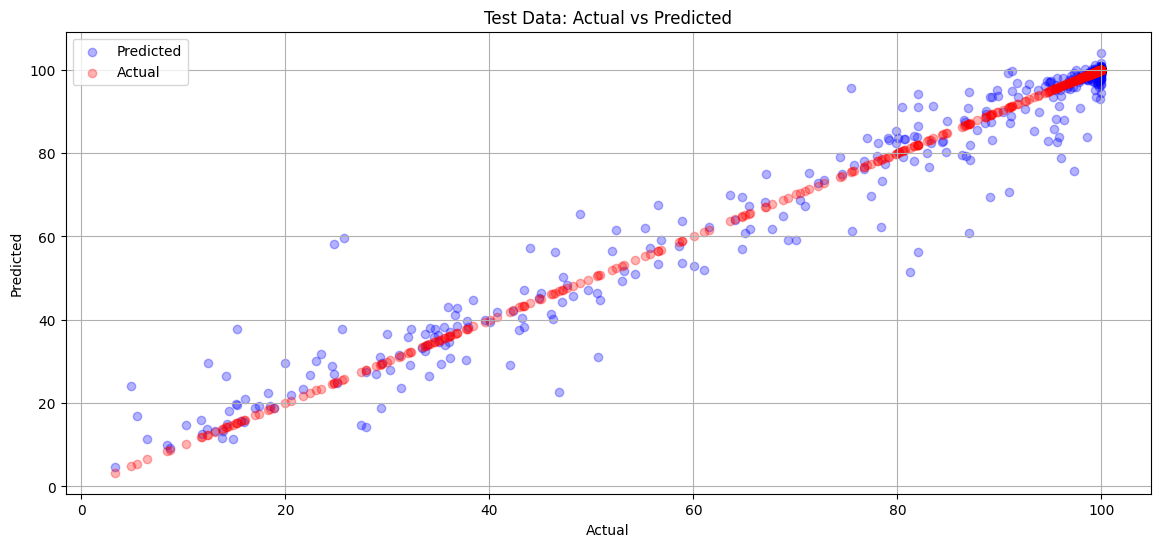

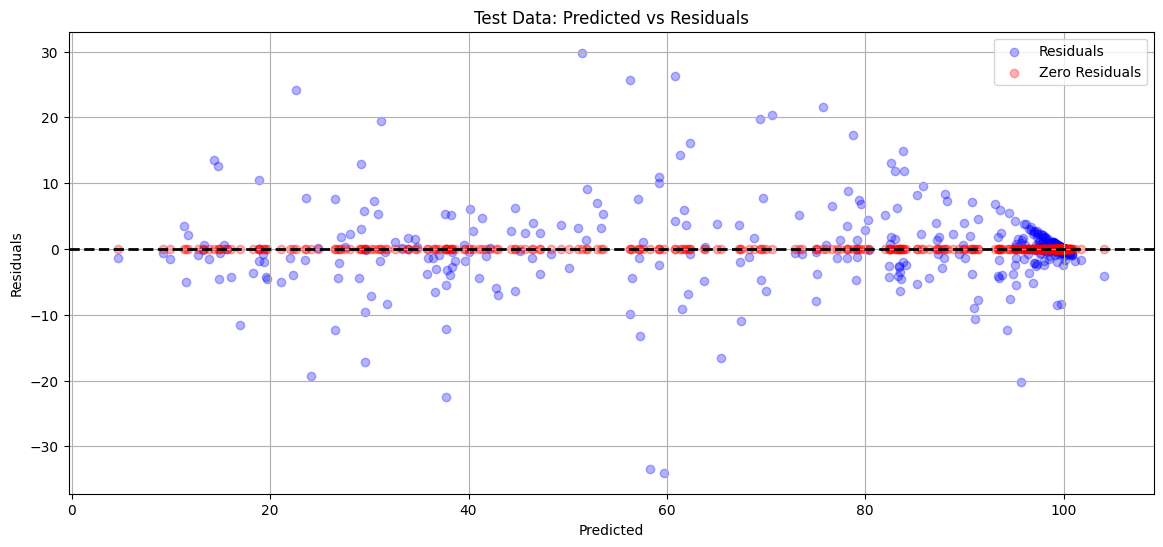

Cross-Validation R-squared Scores: [0.94039893 0.9601444  0.95530519 0.9486734  0.92018353]
Mean Cross-Validation R-squared: 0.9449410903429518
Performance Scores: {'Train MSE': 0.008694544531992246, 'Test MSE': 26.939219158710067, 'Test MAE': 2.472093135580718, 'Test R-squared': 0.9634998808367592, 'Cross-Validation R-squared Scores': array([0.94039893, 0.9601444 , 0.95530519, 0.9486734 , 0.92018353]), 'Mean Cross-Validation R-squared': 0.9449410903429518}


In [52]:
# Visualize Predictions vs. Actual Values for Test Data
plt.figure(figsize=(14, 6))
plt.scatter(y_test, y_pred_test_3, alpha=0.3, color='blue', label='Predicted')
plt.scatter(y_test, y_test, alpha=0.3, color='red', label='Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Data: Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()


# Visualize Residuals for Test Data
test_residuals = y_test - y_pred_test_3
plt.figure(figsize=(14, 6))
plt.scatter(y_pred_test_3, test_residuals, alpha=0.3, color='blue', label='Residuals')
plt.scatter(y_pred_test_3, [0]*len(y_pred_test_3), alpha=0.3, color='red', label='Zero Residuals')
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Test Data: Predicted vs Residuals')
plt.legend()
plt.grid(True)
plt.show()


# Cross-validation results
cv_results = cross_val_score(best_model_3, X_train_df, y_train, cv=kf, scoring='r2')
print(f"Cross-Validation R-squared Scores: {cv_results}")
print(f"Mean Cross-Validation R-squared: {np.mean(cv_results)}")

# Display all performance scores
performance_scores = {
    "Train MSE": train_mse,
    "Test MSE": test_mse,
    "Test MAE": mae_test,
    "Test R-squared": r2_test,
    "Cross-Validation R-squared Scores": cv_results,
    "Mean Cross-Validation R-squared": np.mean(cv_results)
}

print("Performance Scores:", performance_scores)

## Save Model

In [54]:
import os, joblib

destination = "./toolkit"

#create a directory if it doesn't exist
if not os.path.exists(destination):
    os.makedirs(destination)

#Create a dictionary  to store the object and their filename
models ={
    "Pipeline":pipeline,
    "model":best_model_3
}

#Loop through the model and save them using joblib.dump()
for name,model in models.items():
    file_path =os.path.join(destination,f"{name}.joblib")
    joblib.dump(model,file_path)